In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pygfunction as gt
import time
import pickle

# This is mostly from the following example:
# 'Simulation of fluid temperatures in a field of multiple boreholes'
# https://pygfunction.readthedocs.io/en/stable/examples/fluid_temperature_multiple_boreholes.html

# All units are in SI units
# distance: m
# density: kg/m^3
# thermal conductivity: W/m/K
# heat capacity: J/kg/K
# etc...

# Soil properties (as chosen in the COMSOL model)
# TODO: consider more realistic assumptions here
T_g = 12     # Undisturbed soil temperature
k_s = 1.2   # Soil thermal conductivity
rho = 1700  # Density of the soil
cp = 1800   # Heat capacity of the soil
alpha = k_s / (rho * cp)

# alpha = 1e-6
print(f"α = {alpha:.2e}")

# Borefield dimensions (lengths and directions)
Hs = np.array([40, 42.4, 32.9, 41.8, 42, 42, 34.95, 43.5, 40])
Nb = len(Hs)
H_mean = Hs.mean()
ts = H_mean ** 2 / (9 * alpha)
dirs = np.array(
    [
        (0, 0, -1),
        (-0.3535533906, -0.3535533906, -0.8660254038),
        (0, -0.5877852523, -0.809016),
        (0.532625912, -0.532625912, -0.657737999),
        (0.4226182617, 0, -0.9063077870),
        (0.495952835, 0.495952835, -0.712784379),
        (-0.245168846, 0.657661762, -0.712301371),
        (-0.473661805, 0.473661805, -0.742488376),
        (-0.3420201433, 0, -0.9396926208),
    ]
)
locs = np.array(
    [
        (0, 0),
        (-0.707 * 0.7, -0.707 * 0.7),
        (0, -0.707 * 0.7),
        (0.707 * 0.7, -0.707 * 0.7),
        (0.707 * 0.7, 0),
        (0.707 * 0.7, 0.707 * 0.7),
        (0, 0.707 * 0.7),
        (-0.707 * 0.7, 0.707 * 0.7),
        (-0.707 * 0.7, 0),
    ]
)
dx, dy, dz = dirs.T
dr = np.sqrt(dx**2 + dy**2)
phi = np.arctan2(dr, -dz)
theta = np.arctan2(dy, dx)

D = 0  # The burried depth is 0 meter
r_b = 0.125  # Borehole radius, including grout

boreholes = [
    gt.boreholes.Borehole(Hs[i], D, r_b, *locs[i], tilt=phi[i], orientation=theta[i])
    for i in range(Nb)
]

for i in range(Nb):
    print(f"H: {Hs[i]:.2f} m,\ttilt: {np.rad2deg(phi[i]):.2f}°")

borefield = gt.borefield.Borefield.from_boreholes(boreholes)

print(f"H_mean: {H_mean:.2f} m,\tsteady state time = {ts / (3600*24*365.25):.2f} years")

# borefield.visualize_field()
# plt.savefig('setup.pdf')
# plt.close()

# Pipe dimensions (coaxial)
r_in_in = 0.022/2    # Inside pipe inner radius
r_in_out = 0.025/2   # Inside pipe outer radius
r_mid_in = 0.029/2   # Middle pipe inner radius
r_mid_out = 0.032/2  # Middle pipe outer radius
r_out_in = 0.155/2   # Outer pipe inside radius
r_out_out = 0.160/2  # Outer pipe outside radius

k_p = 0.19    # Pipe thermal conductivity
# k_p = 0.05
k_g = 2.0     # Grout thermal conductivity
k_gap = 0.026 # Thermal conductivity of the air between the inner and middle pipe

pos = (0, 0) # position with respect to the borehole
r_inner = np.array([r_in_in, r_out_in])
r_outer = np.array([r_mid_out, r_out_out]) # regard the OD of the middle pipe as the OD

# Fluid properties; NOTE: these are different from the values used in COMSOL
# https://pygfunction.readthedocs.io/en/stable/modules/media.html
fluid = gt.media.Fluid('MEG', 14) # 14% ethylene glycol in water at T=20°C
cp_f = fluid.cp     # Fluid specific isobaric heat capacity
rho_f = fluid.rho   # Fluid density
mu_f = fluid.mu     # Fluid dynamic viscosity (kg/m.s)
k_f = fluid.k       # Fluid thermal conductivity

flow_rate = 3    # Flow rate in m^3/hour; # TODO: verify this
m_flow_borehole = flow_rate/3600*rho_f/Nb # Total fluid mass flow rate per borehole (kg/s)

# For the convection and conduction calculations we use the functions from the pygfunction library.
# These are different from the formulas used in COMSOL.
epsilon = 1.0e-6  # Pipe roughness (m); TODO: validate this

# Pipe conduction thermal resistances
R_in_pipe = gt.pipes.conduction_thermal_resistance_circular_pipe(r_in_in, r_in_out, k_p)
R_mid_pipe = gt.pipes.conduction_thermal_resistance_circular_pipe(r_mid_in, r_mid_out, k_p)
R_mid_gap = gt.pipes.conduction_thermal_resistance_circular_pipe(r_in_out, r_mid_in, k_gap)
R_out_pipe = gt.pipes.conduction_thermal_resistance_circular_pipe(r_out_in, r_out_out, k_p)
R_grout = gt.pipes.conduction_thermal_resistance_circular_pipe(r_out_out, r_b, k_g)

# Fluid convection thermal resistances
h_f_in = gt.pipes.convective_heat_transfer_coefficient_circular_pipe(
        m_flow_borehole, r_in_in, mu_f, rho_f, k_f, cp_f, epsilon)
R_in_conv = 1 / (h_f_in * 2 * np.pi * r_in_in)

h_f_ann_inner, h_f_ann_outer = gt.pipes.convective_heat_transfer_coefficient_concentric_annulus(
            m_flow_borehole, r_mid_out, r_out_in, mu_f, rho_f, k_f, cp_f, epsilon)
R_ann_out_conv = 1 / (h_f_ann_outer * 2 * np.pi * r_out_in)
R_ann_in_conv = 1 / (h_f_ann_inner * 2 * np.pi * r_mid_out)

R_ff = R_in_conv + R_in_pipe + R_mid_gap + R_mid_pipe + R_ann_in_conv
R_fp = R_out_pipe + R_ann_out_conv

print(f'{h_f_in = :.3f} {h_f_ann_inner = :.3f} {h_f_ann_outer = :.3f}')
print(f'{R_ff = :.3f}, {R_fp = :.3f}, {R_out_pipe = :.3f}, {R_grout = :.3f}, ')


pipes = []
for borehole in boreholes:
    pipe = gt.pipes.Coaxial(pos, r_inner, r_outer, borehole, k_s, k_g, R_ff, R_fp, J=2)
    pipes.append(pipe)

    R_b = pipe.effective_borehole_thermal_resistance(
        m_flow_borehole, fluid.cp)
    print(f'Coaxial tube borehole thermal resistance: {R_b:.4f} m.K/W')

network = gt.networks.Network(
    boreholes,
    pipes,
    m_flow_network=m_flow_borehole*Nb,  # Initial flow estimate
    cp_f=cp_f
)


with open('./outputs/EnergyMeter_outputs.pkl', 'rb') as f:
    aggregated_df = pickle.load(f)['aggregated_df'][:2880]

# divide values from the  by 4, because the values are summed
Nt = len(aggregated_df)
Q_tot = aggregated_df['Power_KW'].to_numpy().clip(0, None)/4*1e3  # negative values are errors, so then we set the power to 0

flow_rate = aggregated_df['Flow_Rate'].to_numpy()/4  # divide by 4, because the values are summed
flow_rate_kgs = m_flow_network / Nb

inlet_temps = aggregated_df['Inlet_Temperature'].to_numpy()/4
outlet_temps = aggregated_df['Return_Temperature'].to_numpy()/4
delta_temps = aggregated_df['Delta_T'].to_numpy()/4
timestamps = aggregated_df.index

dt = 3600
tmax = len(Q_tot) * 3600
LoadAgg = gt.load_aggregation.ClaessonJaved(dt, tmax)
time_req = LoadAgg.get_times_for_simulation()

# time_arr = gt.utilities.time_geometric(3600, 20 * 8766 * 3600, 8)
gfunc = gt.gfunction.gFunction(
    network,
    alpha,
    time=time_req,
    boundary_condition="MIFT",
    method="similarities",
    options={'disp': True}
)
# gfunc.visualize_g_function()
# plt.savefig('gfunc.pdf')

LoadAgg.initialize(gfunc.gFunc / (2 * np.pi * k_s))

T_b = np.zeros(Nt)
T_f_in = np.zeros(Nt)
T_f_out = np.zeros(Nt)

for i in range(Nt):
    if i % 50 == 0:
        print(f'{i*100/Nt:.2f}%', end='\r')

    # Increment time step by (1)
    LoadAgg.next_time_step(i*3600)

    Q_i = Q_tot[i]

    # Apply current load (in watts per meter of borehole)
    q_b = Q_i/Hs.sum()
    LoadAgg.set_current_load(q_b)

    # Evaluate borehole wall temperature
    deltaT_b = LoadAgg.temporal_superposition()
    T_b[i] = T_g - deltaT_b

    # Evaluate inlet fluid temperature (all boreholes are the same)
    T_f_in[i] = network.get_network_inlet_temperature(
            Q_tot[i], T_b[i], m_flow_network[i]+0.01, cp_f, nSegments=12)

    # Evaluate outlet fluid temperature
    T_f_out[i] = network.get_network_outlet_temperature(
            T_f_in[i],  T_b[i], m_flow_network[i]+0.01, cp_f, nSegments=12)

    Q_calc = 3/3600*rho_f * cp_f * (T_f_out[i] - T_f_in[i])
    q_calc = Q_calc/Hs.sum()
    # print(f'{q_b = :.3f}, {q_calc = :.3f}, {q_b/q_calc}')


α = 3.92e-07
H: 40.00 m,	tilt: 0.00°
H: 42.40 m,	tilt: 30.00°
H: 32.90 m,	tilt: 36.00°
H: 41.80 m,	tilt: 48.87°
H: 42.00 m,	tilt: 25.00°
H: 42.00 m,	tilt: 44.54°
H: 34.95 m,	tilt: 44.58°
H: 43.50 m,	tilt: 42.06°
H: 40.00 m,	tilt: 20.00°
H_mean: 39.95 m,	steady state time = 14.33 years
h_f_in = 803.797 h_f_ann_inner = 34.333 h_f_ann_outer = 18.277
R_ff = 1.406, R_fp = 0.139, R_out_pipe = 0.027, R_grout = 0.036, 
Coaxial tube borehole thermal resistance: 0.1825 m.K/W
Coaxial tube borehole thermal resistance: 0.1835 m.K/W
Coaxial tube borehole thermal resistance: 0.1799 m.K/W
Coaxial tube borehole thermal resistance: 0.1833 m.K/W
Coaxial tube borehole thermal resistance: 0.1833 m.K/W
Coaxial tube borehole thermal resistance: 0.1833 m.K/W
Coaxial tube borehole thermal resistance: 0.1806 m.K/W
Coaxial tube borehole thermal resistance: 0.1840 m.K/W
Coaxial tube borehole thermal resistance: 0.1825 m.K/W
Identifying similarities ... 0.029 sec
---------------------------------------------------

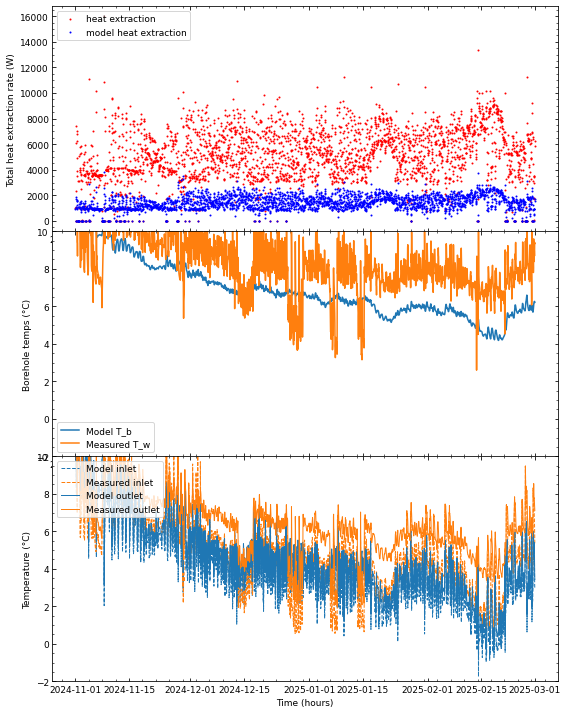

In [25]:

# Configure figure and axes
fig = gt.utilities._initialize_figure()
fig.set_size_inches(8, 10)

ax1 = fig.add_subplot(311)
plt.sca(ax1)
# Axis labels
plt.ylabel(r'Total heat extraction rate (W)')
gt.utilities._format_axes(plt.gca())

# Plot heat extraction rates
plt.scatter(timestamps, Q_tot, c='red', s=1, label='heat extraction')
m_dot = 3/3600*rho_f
Q_calc = m_dot * cp_f * (T_f_out - T_f_in)
plt.scatter(timestamps, Q_calc, c='blue', s=1, label='model heat extraction')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(312, sharex = ax1)
plt.sca(ax2)
plt.ylabel(r'Borehole temps (°C)')
gt.utilities._format_axes(plt.gca())
plt.plot(timestamps, T_b, c='tab:blue', label='Model T_b')
T_m = (inlet_temps + outlet_temps)/2
T_w = T_m + Q_tot/Hs.sum()*0.18
plt.plot(timestamps, T_w, c='tab:orange', label='Measured T_w')
plt.ylim(-2, 10)
plt.legend()



# # ax2.plot(timestamps, T_b, label='Borehole wall')
# ax2.plot(timestamps, T_f_in, label='Model inlet')
# ax2.plot(timestamps, inlet_temps, label='Measured inlet')
# ax2.legend(loc='upper left')

ax3 = fig.add_subplot(313, sharex = ax1)
plt.sca(ax3)
plt.xlabel(r'Time (hours)')
plt.ylabel(r'Temperature (°C)')
gt.utilities._format_axes(plt.gca())

plt.plot(timestamps, T_f_in, c='tab:blue', lw=1, ls='--', label='Model inlet')
plt.plot(timestamps, inlet_temps, c='tab:orange', lw=1, ls='--', label='Measured inlet')
plt.plot(timestamps, T_f_out, c='tab:blue', lw=1, ls='-', label='Model outlet')
plt.plot(timestamps, outlet_temps, c='tab:orange', lw=1, ls='-', label='Measured outlet')
plt.ylim(-2, 10)
plt.legend(loc='upper left')

# Adjust to plot window
plt.tight_layout()
plt.subplots_adjust(hspace=.0)
# plt.savefig('network-data.pdf')
# plt.savefig('network-data.png', dpi=360)
plt.show()
